In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout # <--- ЗМІНА
from tensorflow.keras.callbacks import EarlyStopping
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8)

In [2]:
train_df = pd.read_csv('../data/train_standard_scaled.csv', index_col='DateTime', parse_dates=True)
test_df = pd.read_csv('../data/test_standard_scaled.csv', index_col='DateTime', parse_dates=True)
TARGET_COLUMN = 'Global_active_power'
FEATURES = [col for col in train_df.columns if col != TARGET_COLUMN]
X_train, y_train = train_df[FEATURES], train_df[TARGET_COLUMN]
X_test, y_test = test_df[FEATURES], test_df[TARGET_COLUMN]

In [3]:
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 24
X_train_seq, y_train_seq = create_sequences(X_train, y_train, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, TIME_STEPS)

In [4]:
# Побудова моделі
gru_model = Sequential()
gru_model.add(GRU(units=50, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))) # <--- ЗМІНА
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=1))

# Компіляція моделі
gru_model.compile(optimizer='adam', loss='mean_squared_error')
print("Архітектура GRU моделі:")
gru_model.summary()

# Рання зупинка
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\nПочинаємо навчання моделі GRU...")
history = gru_model.fit(X_train_seq, y_train_seq,
                        epochs=50,
                        batch_size=32,
                        validation_split=0.1,
                        callbacks=[early_stopping],
                        verbose=1)
print("Навчання завершено.")

Архітектура GRU моделі:


/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         8,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,901 (34.77 KB)

 Trainable params: 8,901 (34.77 KB)

 Non-trainable params: 0 (0.00 B)


Починаємо навчання моделі GRU...
Epoch 1/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: nan - val_loss: nan
Epoch 2/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: nan - val_loss: nan
Epoch 3/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: nan - val_loss: nan
Epoch 4/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: nan - val_loss: nan
Epoch 5/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: nan - val_loss: nan
Epoch 6/50
777/777 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: nan - val_loss: nan
Навчання завершено.


216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
--- ДІАГНОСТИКА ---
Кількість NaN одразу після прогнозу: 6888
Кількість нескінченних значень (inf): 0
Кількість NaN після очищення: 0
--------------------
NaNs у фінальних фактичних значеннях: 0
NaNs у фінальних прогнозах: 0

GRU Mean Absolute Error (MAE): 20.21
GRU Root Mean Squared Error (RMSE): 32.35


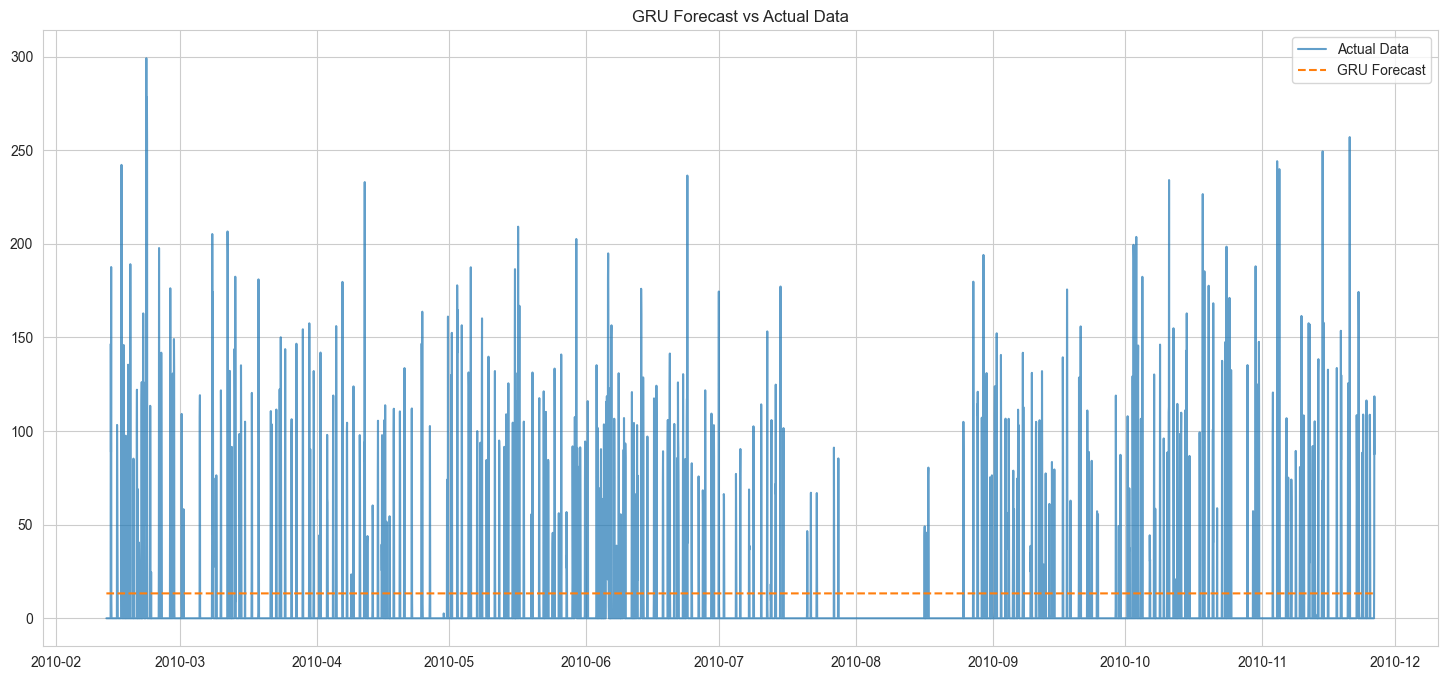

In [5]:
# --- ФІНАЛЬНА ВЕРСІЯ З ДОДАТКОВОЮ ДІАГНОСТИКОЮ ---

# Робимо прогноз на тестових даних
predictions_gru_scaled = gru_model.predict(X_test_seq)


# --- ДІАГНОСТИЧНИЙ КРОК 1: Перевіряємо вихід моделі ---
print("--- ДІАГНОСТИКА ---")
print(f"Кількість NaN одразу після прогнозу: {np.isnan(predictions_gru_scaled).sum()}")
print(f"Кількість нескінченних значень (inf): {np.isinf(predictions_gru_scaled).sum()}")

# ЗАХИСНИЙ МЕХАНІЗМ: Замінюємо будь-які NaN/inf на 0, щоб уникнути помилок далі
predictions_gru_scaled = np.nan_to_num(predictions_gru_scaled)
print(f"Кількість NaN після очищення: {np.isnan(predictions_gru_scaled).sum()}")
print("--------------------")


# Завантажуємо скейлер, який ми зберегли раніше
scaler = joblib.load('../models/standard_scaler.pkl')

# Готуємо датафрейм для зворотного перетворення
test_df_for_inverse = test_df.iloc[TIME_STEPS:].copy()
target_col_index = test_df.columns.get_loc(TARGET_COLUMN)


# 2. Для прогнозів: вставляємо очищені прогнози в стовпець
test_df_for_inverse[TARGET_COLUMN] = predictions_gru_scaled.ravel()
# Виконуємо зворотне перетворення
predictions_gru = scaler.inverse_transform(test_df_for_inverse)[:, target_col_index]

# 3. Для фактичних значень: вставляємо реальні значення
test_df_for_inverse[TARGET_COLUMN] = y_test_seq.ravel()
# Виконуємо зворотне перетворення
y_test_inversed = scaler.inverse_transform(test_df_for_inverse)[:, target_col_index]


# --- Оцінка та Візуалізація ---

# Перевіряємо на NaN ще раз перед розрахунком метрик
print(f"NaNs у фінальних фактичних значеннях: {np.isnan(y_test_inversed).sum()}")
print(f"NaNs у фінальних прогнозах: {np.isnan(predictions_gru).sum()}")

# Розрахунок метрик
mae_gru = mean_absolute_error(y_test_inversed, predictions_gru)
rmse_gru = np.sqrt(mean_squared_error(y_test_inversed, predictions_gru))

print(f"\nGRU Mean Absolute Error (MAE): {mae_gru:.2f}")
print(f"GRU Root Mean Squared Error (RMSE): {rmse_gru:.2f}")

# Візуалізація результатів
plt.plot(test_df.index[TIME_STEPS:], y_test_inversed, label='Actual Data', alpha=0.7)
plt.plot(test_df.index[TIME_STEPS:], predictions_gru, label='GRU Forecast', linestyle='--')
plt.title('GRU Forecast vs Actual Data')
plt.legend()
plt.show()

In [6]:
gru_model.save('../models/gru_model.keras')
print("Модель GRU успішно збережена.")

Модель GRU успішно збережена.
